# Libraries

In [17]:
pip install optuna

In [18]:
  pip install gensim

In [19]:
pip install catboost

In [20]:
pip install ace_tools_open

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, hamming_loss, precision_score, recall_score
from sklearn.model_selection import train_test_split
import optuna
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import ace_tools_open as tools

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, LSTM, Bidirectional, Embedding, TextVectorization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

import joblib
# from google.colab import files


In [22]:
# !pip freeze > requirements.txt

# Dataset

## Preparation

In [25]:
dataset = pd.read_csv('movies.csv', on_bad_lines='skip')
print(dataset.shape)

dataset = dataset[dataset['description'] != 'Add a Plot']
dataset = dataset[dataset['description'] != 'Plot under wraps.']
dataset = dataset[dataset['description'] != 'Plot kept under wraps.']
dataset = dataset[dataset['description'] != 'Plot unknown.']

dataset.shape


(118371, 2)


(117891, 2)

In [26]:
dataset.describe(include='all')

,genre,description
count,117846,117891
unique,566,117495
top,Drama,Grammy - music award of the American academy o...
freq,27760,22


In [27]:
dataset.drop_duplicates(inplace=True)
dataset.describe(include='all')

,genre,description
count,117501,117546
unique,566,117495
top,Drama,The poor ghost of Sir Simon Canterville has be...
freq,27652,4


In [28]:
if dataset.isnull().values.any():
    print("There are missing values in the dataset.")
    print(dataset.isnull().sum())
    dataset.dropna(inplace=True)
    print("\nAfter dropping this rows")
    print(dataset.isnull().sum())
else:
    print("There are no missing values in the dataset.")

dataset.reset_index(drop=True, inplace=True)
dataset.describe(include='all')

There are missing values in the dataset.
genre          45
description     0
dtype: int64

After dropping this rows
genre          0
description    0
dtype: int64


,genre,description
count,117501,117501
unique,566,117451
top,Drama,The Pickwick Club sends Mr. Pickwick and a gro...
freq,27652,4


Top 10 combinations genre
Drama          27652
Documentary    26636
Comedy         15627
Short          10122
Horror          4468
Thriller        3240
Action          2651
Western         2066
Reality-Tv      1763
Family          1573
Name: count, dtype: int64

Bottom 10 combinations genre
Animation, Comedy, Music     1
Crime, Fantasy, Romance      1
Animation, Adventure         1
Comedy, Family, Sci-Fi       1
Animation, Crime, History    1
Animation, Comedy, Crime     1
Action, Fantasy, Thriller    1
Family, Talk-Show            1
History, War                 1
Animation, Action, Sport     1
Name: count, dtype: int64


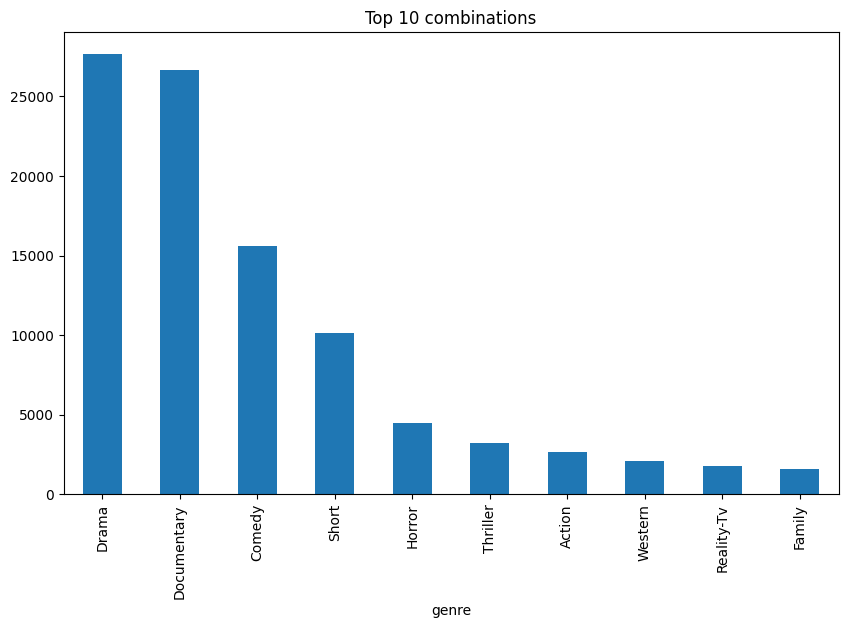

In [29]:
combinations = dataset['genre'].value_counts()
print("Top 10 combinations", combinations.head(10))
print("\nBottom 10 combinations", combinations.tail(10))

top_10_combinations = combinations.head(10)
plt.figure(figsize=(10, 6))
top_10_combinations.plot(kind='bar')
plt.title("Top 10 combinations")
plt.show()

In [30]:
dataset['genre'] = dataset['genre'].apply(lambda x: [g.strip().lower() for g in x.split(',')] if isinstance(x, str) else [])

mlb = MultiLabelBinarizer()
genres_encoded = mlb.fit_transform(dataset['genre'])
genre_columns = mlb.classes_

genre_df = pd.DataFrame(genres_encoded, columns=genre_columns)
dataset = pd.concat([dataset, genre_df], axis=1)

dataset.drop('genre', axis=1, inplace=True)

print(dataset.shape)
dataset.head()

(117501, 29)


,description,action,adult,adventure,animation,biography,comedy,crime,documentary,drama,...,news,reality-tv,romance,sci-fi,short,sport,talk-show,thriller,war,western
0,Decades after their 1984 All Valley Karate Tou...,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Follows the political rivalries and romance of...,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,The trials and tribulations of criminal lawyer...,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,When a psychiatrist shelters a mysterious cult...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,A Street Kid trying to survive in a technology...,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## EDA

Συχνότητα ανά κατηγορία:
drama          31167
documentary    27444
comedy         17794
short          10412
horror          4924
action          4523
thriller        4042
adventure       3059
crime           2462
animation       2357
romance         2304
reality-tv      2204
western         2095
family          2010
music           1660
sci-fi          1581
mystery         1390
adult           1179
fantasy         1159
sport           1044
biography        910
history          892
talk-show        823
musical          628
game-show        472
news             384
war              336
film-noir         12
dtype: int64


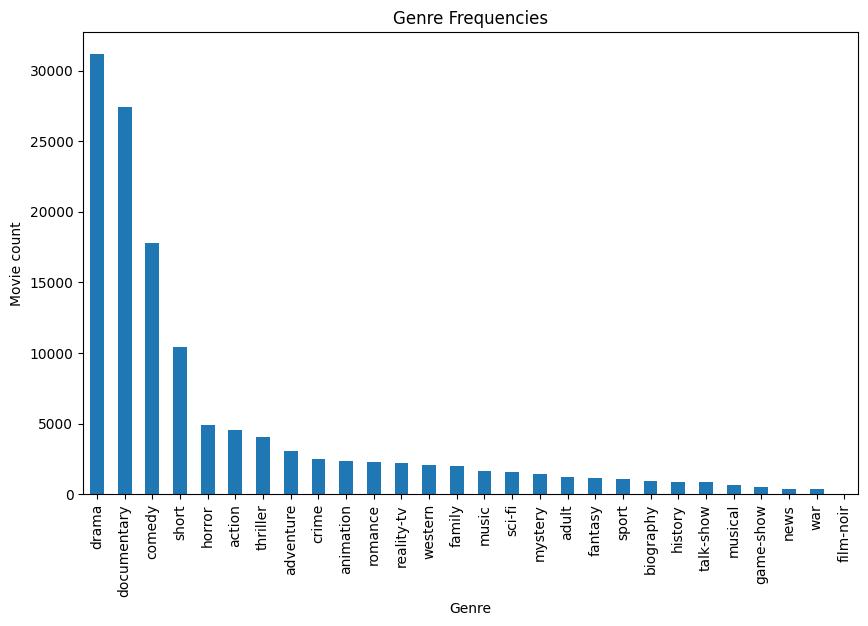

In [31]:
genre_frequencies = genre_df.sum(axis=0).sort_values(ascending=False)

print("Συχνότητα ανά κατηγορία:")
print(genre_frequencies)

plt.figure(figsize=(10, 6))
genre_frequencies.sort_values(ascending=False).plot(kind='bar')
plt.title("Genre Frequencies")
plt.xlabel("Genre")
plt.ylabel("Movie count")
plt.show()

Number of genres assigned to each movie
count    117501.000000
mean          1.100135
std           0.413267
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           3.000000
dtype: float64


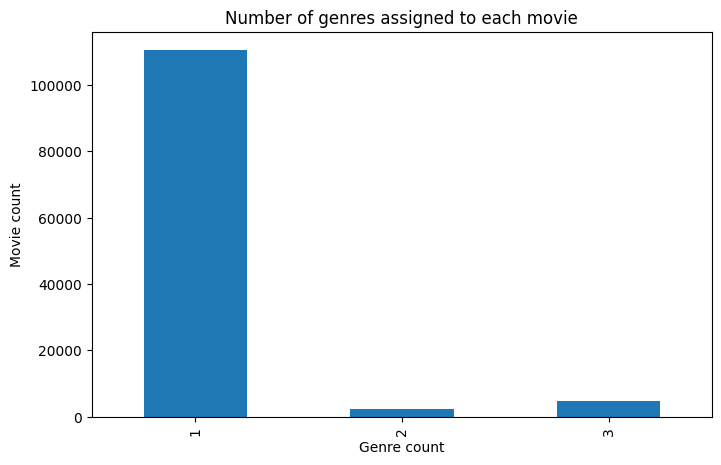

In [32]:
num_genres_per_movie = genre_df.sum(axis=1)

print("Number of genres assigned to each movie")
print(num_genres_per_movie.describe())

plt.figure(figsize=(8, 5))
num_genres_per_movie.value_counts().sort_index().plot(kind='bar')
plt.title("Number of genres assigned to each movie")
plt.xlabel("Genre count")
plt.ylabel("Movie count")
plt.show()


In [33]:
max_freq = genre_frequencies.max()
min_freq = genre_frequencies.min()
print(f"Η πιο συχνή κατηγορία εμφανίζεται {max_freq} φορές.")
print(f"Η πιο σπάνια κατηγορία εμφανίζεται {min_freq} φορές.")

Η πιο συχνή κατηγορία εμφανίζεται 31167 φορές.
Η πιο σπάνια κατηγορία εμφανίζεται 12 φορές.


Παρατηρείται ότι υπάρχει έντονη ανισορροπία στο σύνολο δεδομένων.

In [34]:
max_description_length = dataset['description'].apply(lambda x: len(x) if isinstance(x, str) else 0).max()
print(f"Ο μέγιστος αριθμός χαρακτήρων που μπορεί να έχει μια περιγραφή είναι: {max_description_length}")

Ο μέγιστος αριθμός χαρακτήρων που μπορεί να έχει μια περιγραφή είναι: 10503


## Correlation

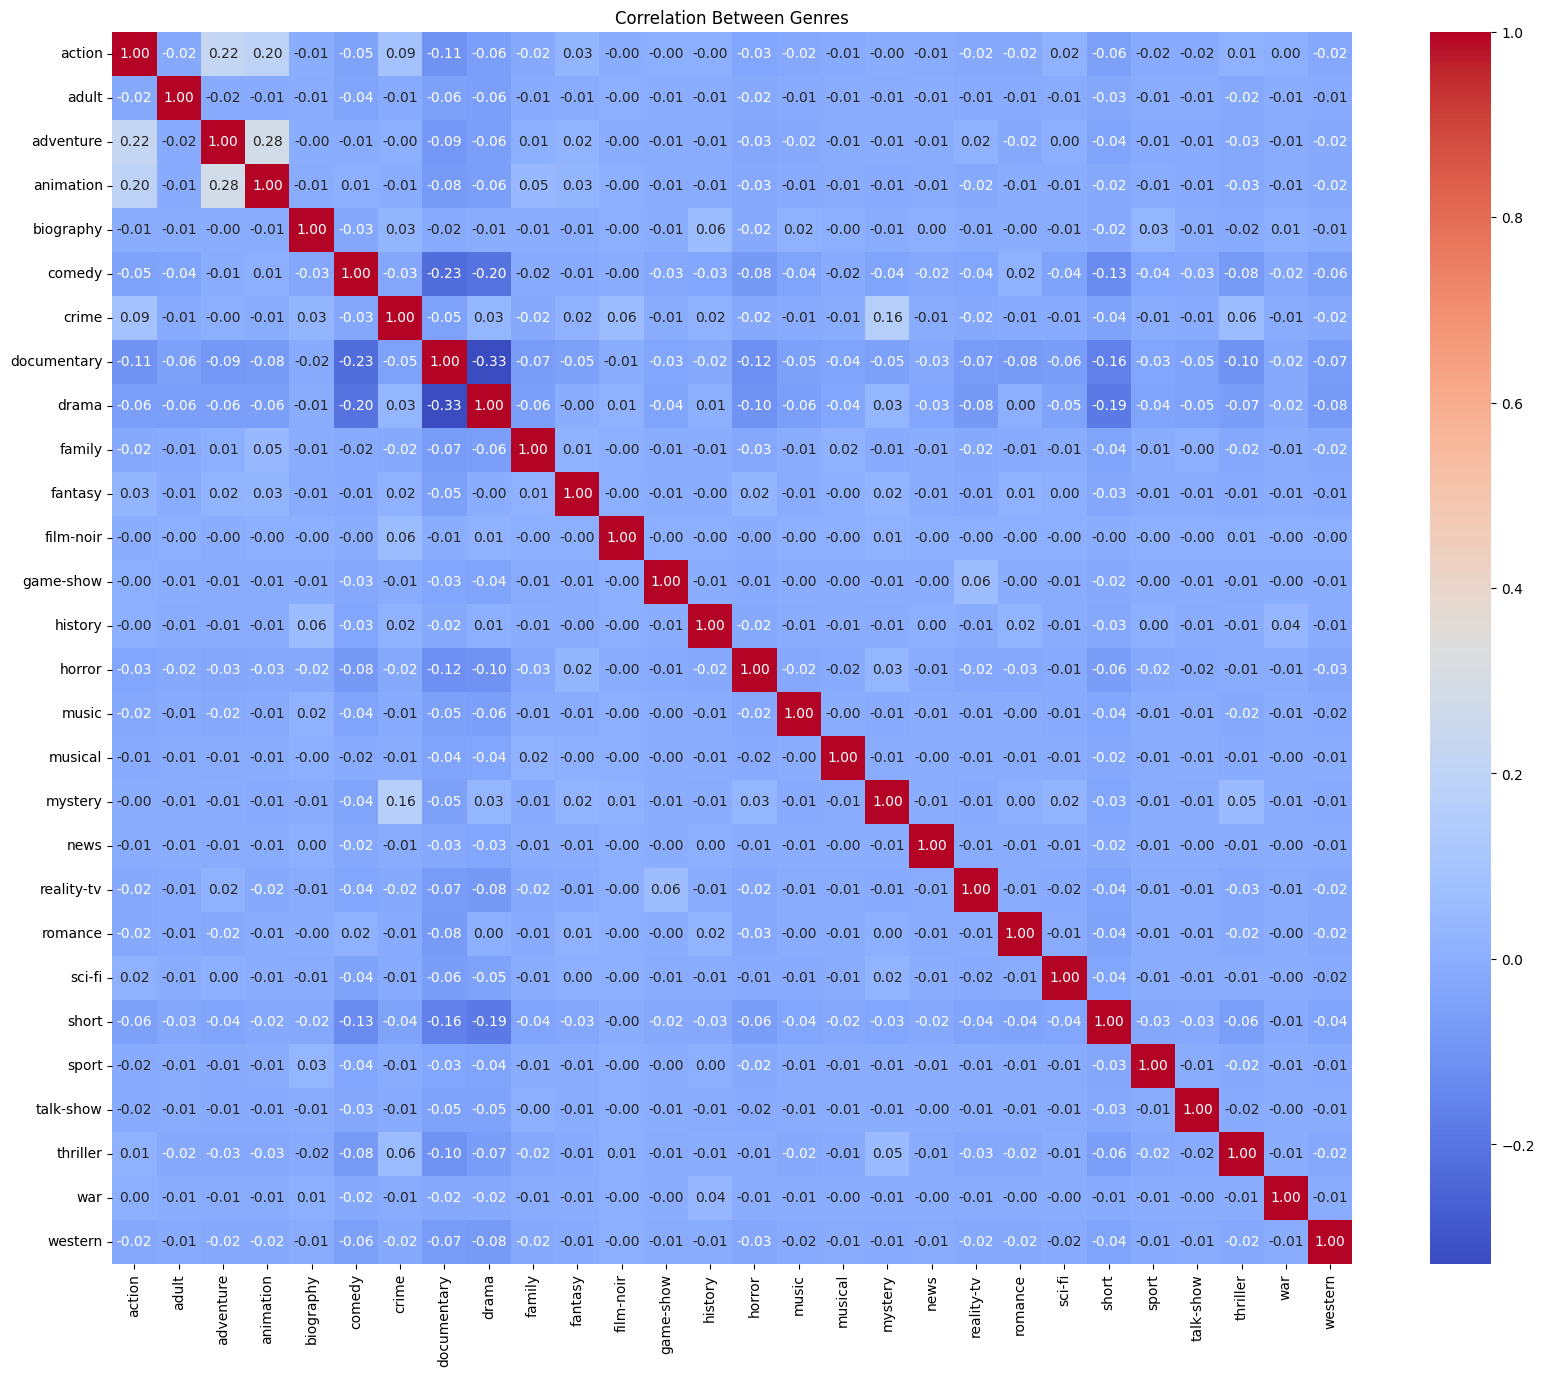

Ζεύγη κατηγοριών με συσχέτιση > 0.3:
Empty DataFrame
Columns: [Genre1, Genre2, Correlation]
Index: []


In [35]:
correlation_matrix = genre_df.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Between Genres")
plt.show()

threshold = 0.3
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Genre1', 'Genre2', 'Correlation']

correlation_pairs = correlation_pairs[
    (correlation_pairs['Correlation'] > threshold) & (correlation_pairs['Genre1'] != correlation_pairs['Genre2'])
]

correlation_pairs = correlation_pairs.drop_duplicates(subset=['Correlation'], keep='first')

correlation_pairs = correlation_pairs.sort_values(by='Correlation', ascending=False)

print("Ζεύγη κατηγοριών με συσχέτιση > 0.3:")
print(correlation_pairs)

# Convert Text

## TF-IDF

In [ ]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(dataset['description'])
print("Shape of X:", X.shape)

y = genres_encoded
print("Shape of y:", y.shape)

## Word2Vec

In [ ]:
nltk.download('punkt')
from nltk import punkt
nltk.download('punkt_tab')

In [ ]:
tokenized_descriptions = dataset['description'].apply(lambda x: word_tokenize(x.lower()) if isinstance(x, str) else [])

w2v_model = Word2Vec(
    sentences=tokenized_descriptions,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,
    epochs=10
)

# w2v_model.save("word2vec.model")

# w2v_model = Word2Vec.load("word2vec.model")


In [ ]:
def get_avg_word2vec(tokens, model, vector_size):
    embeddings = [model.wv[word] for word in tokens if word in model.wv]
    if len(embeddings) > 0:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(vector_size)

X = np.array([
    get_avg_word2vec(tokens, w2v_model, vector_size=100)
    for tokens in tokenized_descriptions
])

print("Shape of X:", X.shape)

y = genres_encoded
print("Shape of y:", y.shape)

## Doc2Vec

In [ ]:
descriptions = dataset['description']
tagged_descriptions = [TaggedDocument(words=word_tokenize(doc.lower()), tags=[str(i)]) for i, doc in enumerate(descriptions)]

# Train a doc2vec model from the start
doc2vec = Doc2Vec(vector_size=300, window=10, min_count=1, workers=2, epochs=50)
doc2vec.build_vocab(tagged_descriptions)
doc2vec.train(tagged_descriptions, total_examples=doc2vec.corpus_count, epochs=doc2vec.epochs)

# # Load a doc2vec model
# doc2vec = Doc2Vec.joblib.load("doc2vec.pkl")
# doc2vec.build_vocab(tagged_descriptions, update=True)
# doc2vec.train(tagged_descriptions, total_examples=doc2vec.corpus_count, epochs=50)
document_vectors = [doc2vec.infer_vector( word_tokenize(doc.lower())) for doc in descriptions]

X = document_vectors
X = np.array(X)
y = genres_encoded

# Split: Train set, val set, test set

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (94000, 100)
Validation set: (11750, 100)
Test set: (11751, 100)


# Train and evaluation

## Time

In [ ]:
import time

def time_model_training(model, X_train, y_train):
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    return elapsed_time

## Models

### Traditional Methods

#### Linear SVM

In [ ]:
def objective_linear_svm(trial):
    """
    Optuna objective function for Linear SVM hyperparameter optimization for multi-label classification.
    """
    params = {
        "C": trial.suggest_loguniform("C", 1e-4, 1e2),
        "max_iter": trial.suggest_int("max_iter", 1000, 10000, step=500),
        "class_weight": trial.suggest_categorical("class_weight", [None, "balanced"])
    }
    model = MultiOutputClassifier(LinearSVC(**params, random_state=42))
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="samples")
    return f1

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

def objective_naive_bayes(trial):
    """
    Optuna objective function for Naive Bayes hyperparameter optimization for multi-label classification.
    """
    var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-11, 1e-3)

    model = MultiOutputClassifier(GaussianNB(var_smoothing=var_smoothing))
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="samples")
    return f1

#### Logistic Regression

In [ ]:
def objective_lr(trial):
    """
    Optuna objective function for Logistic Regression hyperparameter optimization for multi-label classification.
    """
    params = {
        'C': trial.suggest_loguniform('C', 1e-4, 1e2),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('max_iter', 100, 5000),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced'])
    }
    model = MultiOutputClassifier(LogisticRegression(**params, random_state=42))
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    score = f1_score(y_val, y_val_pred, average="samples")
    return score

### Ensemble Methods

#### XGBClassifier

In [ ]:
def objective_xgboost(trial):
    """
    Optuna objective function for XGBoost hyperparameter optimization for multi-label classification.
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42
    }

    model = MultiOutputClassifier(XGBClassifier(**params, eval_metric="logloss"))
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="samples")
    return f1


#### LGBMClassifier

In [ ]:
def objective_lightgbm(trial):
    """
    Optuna objective function for LightGBM hyperparameter optimization for multi-label classification.
    """
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=50),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 0, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 0, 1),
        "random_state": 42
    }

    model = MultiOutputClassifier(LGBMClassifier(**params, verbose=-1))
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    f1 = f1_score(y_val, y_val_pred, average="samples")
    return f1

## Final Models

In [ ]:
# Linear SVM
study_linear_svm = optuna.create_study(direction='maximize')
study_linear_svm.optimize(objective_linear_svm, n_trials=10)

best_model_linear_svm = MultiOutputClassifier(LinearSVC(**study_linear_svm.best_params, random_state=42))
best_model_linear_svm.fit(X_train, y_train)

training_time_linear_svm = time_model_training(best_model_linear_svm, X_train, y_train)

y_pred_linear_svm = best_model_linear_svm.predict(X_test)

model_data = {
    "model": best_model_linear_svm,
    "training_time": training_time_linear_svm
}
joblib.dump(model_data, "linear_svm_model.pkl")
print("Model saved as linear_svm_model.pkl")

In [ ]:
# Naive Bayes
study_naive_bayes = optuna.create_study(direction='maximize')
study_naive_bayes.optimize(objective_naive_bayes, n_trials=10)

best_model_naive_bayes = MultiOutputClassifier(GaussianNB(**study_naive_bayes.best_params))
best_model_naive_bayes.fit(X_train, y_train)

training_time_naive_bayes = time_model_training(best_model_naive_bayes, X_train, y_train)

y_pred_naive_bayes = best_model_naive_bayes.predict(X_test)

model_data = {
    "model": best_model_naive_bayes,
    "training_time": training_time_naive_bayes
}
joblib.dump(model_data, "naive_bayes_model.pkl")
print("Model saved as naive_bayes_model.pkl")

[I 2025-01-23 08:58:27,674] A new study created in memory with name: no-name-2c7ea07b-7497-44e9-92cb-8f530795d8d6
<ipython-input-28-71db3e49a2c9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-11, 1e-3)
[I 2025-01-23 08:58:30,749] Trial 0 finished with value: 0.31967322602303827 and parameters: {'var_smoothing': 1.1476021843724155e-06}. Best is trial 0 with value: 0.31967322602303827.
<ipython-input-28-71db3e49a2c9>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  var_smoothing = trial.suggest_loguniform("var_smoothing", 1e-11, 1e-3)
[I 2025-01-23 08:58:34,242] Trial 1 finished with value: 0.3196732260230382

Model saved as naive_bayes_model.pkl


In [ ]:
# Logistic Regression
study_lr = optuna.create_study(direction='maximize')
study_lr.optimize(objective_lr, n_trials=10)

best_model_lr = MultiOutputClassifier(LogisticRegression(**study_lr.best_params, random_state=42))
best_model_lr.fit(X_train, y_train)

training_time_lr = time_model_training(best_model_lr, X_train, y_train)

y_pred_lr = best_model_lr.predict(X_test)

model_data = {
    "model": best_model_lr,
    "training_time": training_time_lr
}
joblib.dump(model_data, "logistic_regression_model.pkl")
print("Model saved as logistic_regression_model.pkl")

[I 2025-01-22 18:41:28,973] A new study created in memory with name: no-name-3efe2106-6058-4638-8bee-c191821812de
<ipython-input-30-bbe65d9521d9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e2),
[I 2025-01-22 18:43:21,310] Trial 0 finished with value: 0.11753191489361701 and parameters: {'C': 0.004958995509130142, 'solver': 'saga', 'max_iter': 1860, 'class_weight': None}. Best is trial 0 with value: 0.11753191489361701.
<ipython-input-30-bbe65d9521d9>:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-4, 1e2),
[I 2025-01-22 18:45:31,982] Trial 1 finished with value: 0.3590755825734549 and

Model saved as logistic_regression_model.pkl


In [ ]:
# XGBoost
study_xgboost = optuna.create_study(direction='maximize')
study_xgboost.optimize(objective_xgboost, n_trials=10)

best_model_xgboost = MultiOutputClassifier(XGBClassifier(**study_xgboost.best_params, eval_metric="logloss"))
best_model_xgboost.fit(X_train, y_train)

training_time_xgboost = time_model_training(best_model_xgboost, X_train, y_train)

y_pred_xgboost = best_model_xgboost.predict(X_test)

model_data = {
    "model": best_model_xgboost,
    "training_time": training_time_xgboost
}
joblib.dump(model_data, "xgboost_model.pkl")
print("Model saved as xgboost_model.pkl")

[I 2025-01-23 08:59:55,140] A new study created in memory with name: no-name-e1e4f94c-d64a-4107-a607-b1f68a2f8cac
[I 2025-01-23 09:14:54,755] Trial 0 finished with value: 0.4332624113475177 and parameters: {'n_estimators': 450, 'max_depth': 6, 'learning_rate': 0.1262902821814632, 'subsample': 0.9160437434603843, 'colsample_bytree': 0.7328424276922947, 'gamma': 0.13674543393982808, 'min_child_weight': 4}. Best is trial 0 with value: 0.4332624113475177.
[I 2025-01-23 09:24:32,318] Trial 1 finished with value: 0.43631144883485307 and parameters: {'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.24344404992685678, 'subsample': 0.647764919565275, 'colsample_bytree': 0.7792718102555668, 'gamma': 0.3411553580384451, 'min_child_weight': 6}. Best is trial 1 with value: 0.43631144883485307.
[I 2025-01-23 09:39:05,515] Trial 2 finished with value: 0.42809848024316105 and parameters: {'n_estimators': 700, 'max_depth': 7, 'learning_rate': 0.1983750369389909, 'subsample': 0.813084865819232, '

In [ ]:
# LightGBM
study_lightgbm = optuna.create_study(direction='maximize')
study_lightgbm.optimize(objective_lightgbm, n_trials=10)

best_model_lightgbm = MultiOutputClassifier(LGBMClassifier(**study_lightgbm.best_params))
best_model_lightgbm.fit(X_train, y_train)

training_time_lightgbm = time_model_training(best_model_lightgbm, X_train, y_train)

y_pred_lightgbm = best_model_lightgbm.predict(X_test)

model_data = {
    "model": best_model_lightgbm,
    "training_time": training_time_lightgbm
}
joblib.dump(model_data, "lightgbm_model.pkl")
print("Model saved as lightgbm_model.pkl")

# Predictions with already trained models (pkl)

In [ ]:
import zipfile
import os

# Unzip Word2Vec.zip
with zipfile.ZipFile('Word2Vec.zip', 'r') as zip_ref:
    zip_ref.extractall('./Word2Vec')

# Unzip Doc2Vec.zip
with zipfile.ZipFile('Doc2Vec.zip', 'r') as zip_ref:
    zip_ref.extractall('./Doc2Vec')

# Unzip TF-IDF.zip
with zipfile.ZipFile('TF-IDF.zip', 'r') as zip_ref:
    zip_ref.extractall('./TF-IDF')

print("Contents of Word2Vec folder:", os.listdir('./Word2Vec'))
print("Contents of Doc2Vec folder:", os.listdir('./Doc2Vec'))
print("Contents of TF-IDF folder:", os.listdir('./TF-IDF'))


In [ ]:
# Load Models
loaded_model_linear_svm_tf = joblib.load("TF-IDF/linear_svm_model.pkl")
loaded_model_naive_bayes_tf = joblib.load("TF-IDF/naive_bayes_model.pkl")
loaded_model_lr_tf = joblib.load("TF-IDF/logistic_regression_model.pkl")
loaded_model_xgboost_tf = joblib.load("TF-IDF/xgboost_model.pkl")
loaded_model_lightgbm_tf = joblib.load("TF-IDF/lightgbm_model.pkl")

loaded_model_linear_svm_w2v = joblib.load("Word2Vec/Word2Vec/linear_svm_model.pkl")
loaded_model_naive_bayes_w2v = joblib.load("Word2Vec/Word2Vec/naive_bayes_model.pkl")
loaded_model_lr_w2v = joblib.load("Word2Vec/Word2Vec/logistic_regression_model.pkl")
loaded_model_xgboost_w2v = joblib.load("Word2Vec/Word2Vec/xgboost_model.pkl")
loaded_model_lightgbm_w2v = joblib.load("Word2Vec/Word2Vec/lightgbm_model.pkl")


loaded_model_linear_svm_d2v = joblib.load("Doc2Vec/linear_svm_model.pkl")
loaded_model_naive_bayes_d2v = joblib.load("Doc2Vec/naive_bayes_model.pkl")
loaded_model_lr_d2v = joblib.load("Doc2Vec/logistic_regression_model.pkl")
loaded_model_xgboost_d2v = joblib.load("Doc2Vec/xgboost_model.pkl")
loaded_model_lightgbm_d2v = joblib.load("Doc2Vec/lightgbm_model.pkl")

In [ ]:
# Predict and evaluate
y_pred_linear_svm_tf = loaded_model_linear_svm_tf['model'].predict(X_test)
y_pred_naive_bayes_tf = loaded_model_naive_bayes_tf['model'].predict(X_test)
y_pred_lr_tf = loaded_model_lr_tf['model'].predict(X_test)
y_pred_xgboost_tf = loaded_model_xgboost_tf['model'].predict(X_test)
y_pred_lightgbm_tf = loaded_model_lightgbm_tf['model'].predict(X_test)


y_pred_linear_svm_w2v = loaded_model_linear_svm_w2v.predict(X_test)
y_pred_naive_bayes_w2v = loaded_model_naive_bayes_w2v['model'].predict(X_test)
y_pred_lr_w2v = loaded_model_lr_w2v['model'].predict(X_test)
y_pred_xgboost_w2v = loaded_model_xgboost_w2v['model'].predict(X_test)
y_pred_lightgbm_w2v = loaded_model_lightgbm_w2v['model'].predict(X_test)


y_pred_linear_svm_d2v = loaded_model_linear_svm_d2v['model'].predict(X_test)
y_pred_naive_bayes_d2v = loaded_model_naive_bayes_d2v['model'].predict(X_test)
y_pred_lr_d2v = loaded_model_lr_d2v['model'].predict(X_test)
y_pred_xgboost_d2v = loaded_model_xgboost_d2v['model'].predict(X_test)
y_pred_lightgbm_d2v = loaded_model_lightgbm_d2v['model'].predict(X_test)

In [ ]:
best_hyperparameters_tf = {
    "Linear SVM": loaded_model_linear_svm_tf['model'].get_params(),
    "Naive Bayes": loaded_model_naive_bayes_tf['model'].get_params(),
    "Logistic Regression": loaded_model_lr_tf['model'].get_params(),
    "XGBoost": loaded_model_xgboost_tf['model'].get_params(),
    "LightGBM": loaded_model_lightgbm_tf['model'].get_params()
}

best_hyperparameters_d2v = {
    "Linear SVM": loaded_model_linear_svm_d2v.get_params(),
    "Naive Bayes": loaded_model_naive_bayes_d2v['model'].get_params(),
    "Logistic Regression": loaded_model_lr_d2v['model'].get_params(),
    "XGBoost": loaded_model_xgboost_d2v['model'].get_params(),
    "LightGBM": loaded_model_lightgbm_d2v['model'].get_params()
}

best_hyperparameters_w2v = {
    "Linear SVM": loaded_model_linear_svm_w2v.get_params(),
    "Naive Bayes": loaded_model_naive_bayes_w2v['model'].get_params(),
    "Logistic Regression": loaded_model_lr_w2v['model'].get_params(),
    "XGBoost": loaded_model_xgboost_w2v['model'].get_params(),
    "LightGBM": loaded_model_lightgbm_w2v['model'].get_params()
}

print("Best Hyperparameters:")
for model, params in best_hyperparameters_tf.items():
    print(f"{model}: {params}")
for model, params in best_hyperparameters_d2v.items():
    print(f"{model}: {params}")
for model, params in best_hyperparameters_w2v.items():
    print(f"{model}: {params}")

In [ ]:
results_tf = {
    "Model": ["Linear SVM", "Naive Bayes", "Logistic Regression", "XGBoost", "LightGBM"],
    "Hamming Loss": [
        hamming_loss(y_test, y_pred_linear_svm_tf),
        hamming_loss(y_test, y_pred_naive_bayes_tf),
        hamming_loss(y_test, y_pred_lr_tf),
        hamming_loss(y_test, y_pred_xgboost_tf),
        hamming_loss(y_test, y_pred_lightgbm_tf),
    ],
    "Training Time (seconds)": [
        loaded_model_linear_svm_tf["training_time"],
        loaded_model_naive_bayes_tf["training_time"],
        loaded_model_lr_tf["training_time"],
        loaded_model_xgboost_tf["training_time"],
        loaded_model_lightgbm_tf["training_time"],
    ],
    "Recall": [
        recall_score(y_test, y_pred_linear_svm_tf, average="samples"),
        recall_score(y_test, y_pred_naive_bayes_tf, average="samples"),
        recall_score(y_test, y_pred_lr_tf, average="samples"),
        recall_score(y_test, y_pred_xgboost_tf, average="samples"),
        recall_score(y_test, y_pred_lightgbm_tf, average="samples"),
    ],
    "Precision": [
        precision_score(y_test, y_pred_linear_svm_tf, average="samples"),
        precision_score(y_test, y_pred_naive_bayes_tf, average="samples"),
        precision_score(y_test, y_pred_lr_tf, average="samples"),
        precision_score(y_test, y_pred_xgboost_tf, average="samples"),
        precision_score(y_test, y_pred_lightgbm_tf, average="samples"),
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_linear_svm_tf, average="samples"),
        f1_score(y_test, y_pred_naive_bayes_tf, average="samples"),
        f1_score(y_test, y_pred_lr_tf, average="samples"),
        f1_score(y_test, y_pred_xgboost_tf, average="samples"),
        f1_score(y_test, y_pred_lightgbm_tf, average="samples"),
    ]
}

results_w2v = {
    "Model": [ "Linear SVM","Naive Bayes", "Logistic Regression", "XGBoost", "LightGBM"],
    "Hamming Loss": [
        hamming_loss(y_test, y_pred_linear_svm_w2v),
        hamming_loss(y_test, y_pred_naive_bayes_w2v),
        hamming_loss(y_test, y_pred_lr_w2v),
        hamming_loss(y_test, y_pred_xgboost_w2v),
        hamming_loss(y_test, y_pred_lightgbm_w2v),
    ],
    "Training Time (seconds)": [
        loaded_model_linear_svm_w2v,
        loaded_model_naive_bayes_w2v["training_time"],
        loaded_model_lr_w2v["training_time"],
        loaded_model_xgboost_w2v["training_time"],
        loaded_model_lightgbm_w2v["training_time"],
    ],
    "Recall": [
        recall_score(y_test, y_pred_linear_svm_w2v, average="samples"),
        recall_score(y_test, y_pred_naive_bayes_w2v, average="samples"),
        recall_score(y_test, y_pred_lr_w2v, average="samples"),
        recall_score(y_test, y_pred_xgboost_w2v, average="samples"),
        recall_score(y_test, y_pred_lightgbm_w2v, average="samples"),
    ],
    "Precision": [
       precision_score(y_test, y_pred_linear_svm_w2v, average="samples"),
        precision_score(y_test, y_pred_naive_bayes_w2v, average="samples"),
        precision_score(y_test, y_pred_lr_w2v, average="samples"),
        precision_score(y_test, y_pred_xgboost_w2v, average="samples"),
        precision_score(y_test, y_pred_lightgbm_w2v, average="samples"),
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_linear_svm_w2v, average="samples"),
        f1_score(y_test, y_pred_naive_bayes_w2v, average="samples"),
        f1_score(y_test, y_pred_lr_w2v, average="samples"),
        f1_score(y_test, y_pred_xgboost_w2v, average="samples"),
        f1_score(y_test, y_pred_lightgbm_w2v, average="samples"),
    ]
}

results_d2v = {
    "Model": ["Linear SVM", "Naive Bayes", "Logistic Regression", "XGBoost", "LightGBM"],
    "Hamming Loss": [
        hamming_loss(y_test, y_pred_linear_svm_d2v),
        hamming_loss(y_test, y_pred_naive_bayes_d2v),
        hamming_loss(y_test, y_pred_lr_d2v),
        hamming_loss(y_test, y_pred_xgboost_d2v),
        hamming_loss(y_test, y_pred_lightgbm_d2v),
    ],
    "Training Time (seconds)": [
        loaded_model_linear_svm_d2v["training_time"],
        loaded_model_naive_bayes_d2v["training_time"],
        loaded_model_lr_d2v["training_time"],
        loaded_model_xgboost_d2v["training_time"],
        loaded_model_lightgbm_d2v["training_time"],
    ],
    "Recall": [
        recall_score(y_test, y_pred_linear_svm_d2v, average="samples"),
        recall_score(y_test, y_pred_naive_bayes_d2v, average="samples"),
        recall_score(y_test, y_pred_lr_d2v, average="samples"),
        recall_score(y_test, y_pred_xgboost_d2v, average="samples"),
        recall_score(y_test, y_pred_lightgbm_d2v, average="samples"),
    ],
    "Precision": [
        precision_score(y_test, y_pred_linear_svm_d2v, average="samples"),
        precision_score(y_test, y_pred_naive_bayes_d2v, average="samples"),
        precision_score(y_test, y_pred_lr_d2v, average="samples"),
        precision_score(y_test, y_pred_xgboost_d2v, average="samples"),
        precision_score(y_test, y_pred_lightgbm_d2v, average="samples"),
    ],
    "F1 Score": [
        f1_score(y_test, y_pred_linear_svm_d2v, average="samples"),
        f1_score(y_test, y_pred_naive_bayes_d2v, average="samples"),
        f1_score(y_test, y_pred_lr_d2v, average="samples"),
        f1_score(y_test, y_pred_xgboost_d2v, average="samples"),
        f1_score(y_test, y_pred_lightgbm_d2v, average="samples"),
    ]
}

df_tf = pd.DataFrame(results_tf)
df_w2v = pd.DataFrame(results_w2v)
df_d2v = pd.DataFrame(results_d2v)

tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=df_tf)
tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=df_w2v)
tools.display_dataframe_to_user(name="Model Evaluation Results", dataframe=df_d2v)
